#                                 Multi-Sensor Image fusion 

The goal of image fusion is to obtain a fused image that contains most significant information in all input images which
were captured by different sensors from the same scene. In particular,
the fusion process should improve the contrast and keep the
integrity of significant features from input images.In this project
multi-sensor image fusion is used to combine the complementary
information of source images from the multiple sensors.


### DATA DESCRIPTION:

The dataset contains multi-sensor images i.e infrared and
visible image.

There are total 30 images in folder(IV images)
, where 15 images are infrared and remaining 15 are visible.

## Importing packages -

In [1]:
from torchvision.models.vgg import vgg19
import torch
from sporco.signal import tikhonov_filter
import numpy as np
import pywt
import matplotlib.pyplot as plt
from imageio import imread
from imageio import imsave
from scipy import linalg as la
import cv2 
import warnings
warnings.filterwarnings('ignore')

G:\anaconda\envs\pytorch1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Visualising the input image

In [2]:
def input_visual_VIS(image):
        gray_img = imread(image) #reading image
        gray_img= cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB) # Adjusting color channels
        gray_img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2GRAY) # changing the color channel from RGB to gray 
        return gray_img
def input_visual_VIS(image):
        ir_img = imread(image)
        ir_img = cv2.cvtColor(ir_img, cv2.COLOR_BGR2RGB) # Adjusting color channels
        ir_img = cv2.cvtColor(ir_img, cv2.COLOR_BGR2GRAY) # changing the color channel from RGB to gray 
        return  ir_img

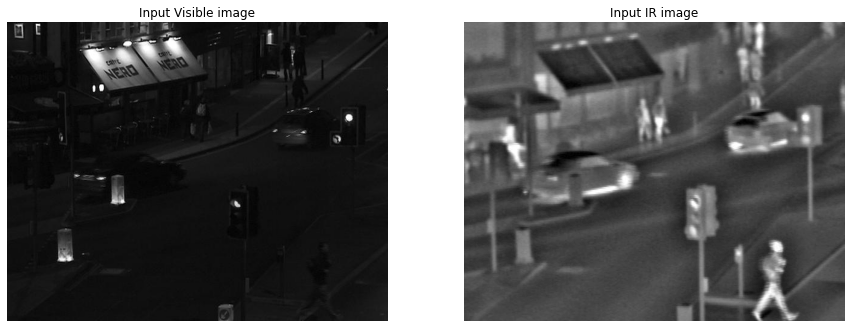

In [3]:
plt.figure(1,figsize=(15,8))
plt.subplot(1, 2, 1)
img1 = input_visual_VIS('IV_images/VIS2.png')
plt.title("Input Visible image")
plt.axis('off')
plt.imshow(img1,cmap="gray")
plt.subplot(1, 2, 2)
img2 = input_visual_VIS('IV_images/IR2.png')
plt.title("Input IR image")
plt.axis('off')
plt.imshow(img2,cmap="gray")

## Function definitions -

In [4]:
def signaltonoise(a, axis, ddof):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def lowpass(s, lda, npad):  # In this function, low pass filtering is done by using Tikhonov filter.
    return tikhonov_filter(s, lda, npad)


def get_activation(model, layer_numbers, input_image):
    outs = []
    out = input_image
    for i in range(max(layer_numbers) + 1):
        with torch.no_grad():  # Reduces memory usage and speeds up calculations
            out = model.features[i](out)
        if i in layer_numbers:
            outs.append(np.rollaxis(out.detach().cpu().numpy()[0], 0, 3))
    return outs


def c3(s):  # Picture 3D is turned into array and rotate.
    if s.ndim == 2:
        s3 = np.dstack([s, s, s])
    else:
        s3 = s
    return np.rollaxis(s3, 2, 0)[None, :, :, :]


def l1_features(out):
    h, w, d = out.shape  # The shape property used to get the current shape of an array (height, width, depth)
    a_temp = np.zeros((h + 2, w + 2))  # All edges of the Matrix have been zero

    l1_norm = np.sum(np.abs(out), axis=2)
    a_temp[1:h + 1, 1:w + 1] = l1_norm
    return a_temp


## 1]Discrete Wavelet Transform

In [5]:
"""
# Performs Image fusion using Discrete wavelet transform (DWT) with Daubechies filter
# input: two Images dataset (matrix) to be fused
# output: one Fused Image dataset (matrix)"""


def Fusion_DWT_db2(image1, image2):
    # decomposing each image using Discrete wavelet transform(DWT) with Daubechies filter (db2)
    coefficients_1 = pywt.wavedec2(image1, 'db2', level=2)
    coefficients_2 = pywt.wavedec2(image2, 'db2', level=2)
    # creating variables to be used
    coefficients_h = list(coefficients_1)
    # fusing the decomposed image data
    coefficients_h[0] = (coefficients_1[0] + coefficients_2[0]) * 0.5
    # creating variables to be used
    temp1 = list(coefficients_1[1])
    temp2 = list(coefficients_2[1])
    temp3 = list(coefficients_h[1])
    # fusing the decomposed image data
    temp3[0] = (temp1[0] + temp2[0]) * 0.5
    temp3[1] = (temp1[1] + temp2[1]) * 0.5
    temp3[2] = (temp1[2] + temp2[2]) * 0.5
    coefficients_h[1] = tuple(temp3)
    # Creating fused image by reconstructing the fused decomposed image
    result = pywt.waverec2(coefficients_h, 'db2')
    return result

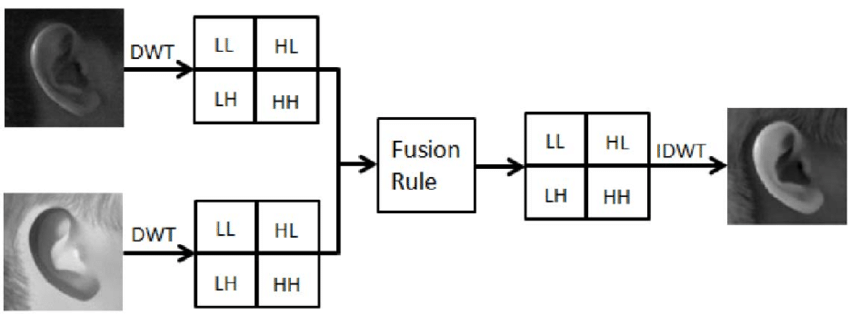

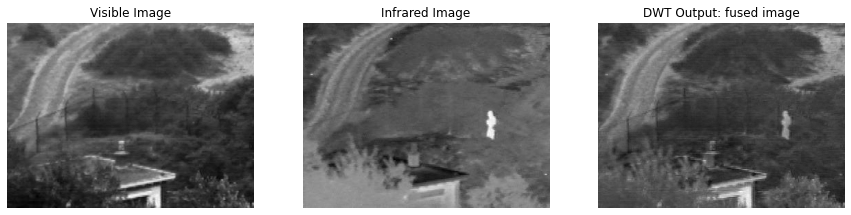

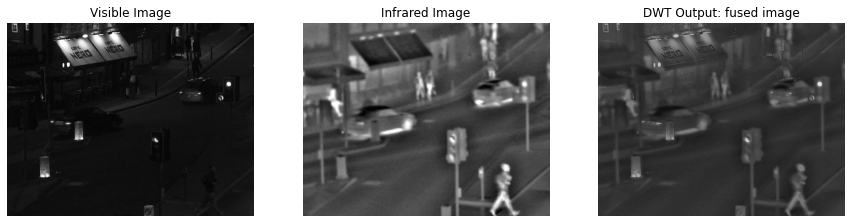

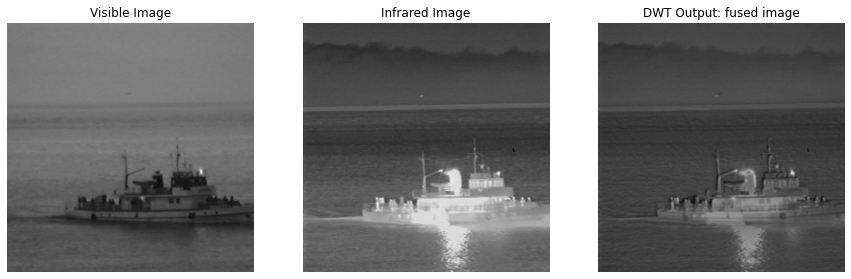

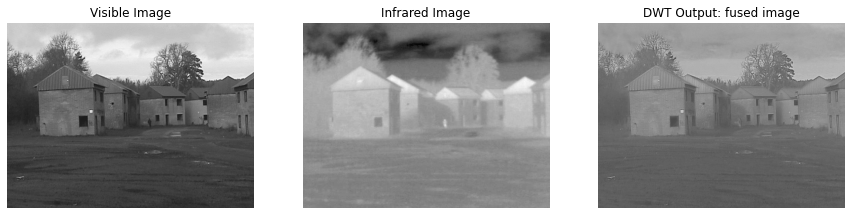

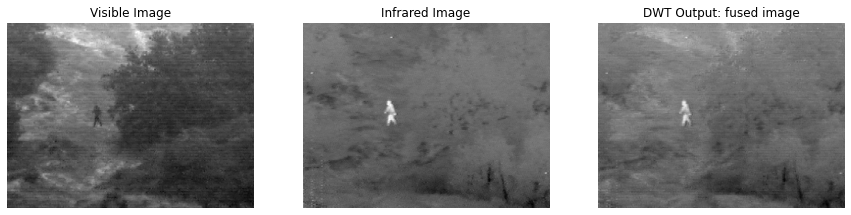

In [6]:
for id_x in range(1, 6, 1):

    gray_img = imread('IV_images/VIS%d.png' % id_x)
    ir_img = imread('IV_images/IR%d.png' % id_x)

    pic = Fusion_DWT_db2(gray_img, ir_img)

    pict = pic * 255
    pict = pict.astype(np.uint8)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(gray_img, 'gray')
    plt.axis('off')
    plt.title('Visible Image')

    plt.subplot(1, 3, 2)
    plt.imshow(ir_img, 'gray')
    plt.axis('off')
    plt.title('Infrared Image')

    plt.subplot(1, 3, 3)
    plt.imshow(pic, 'gray')
    plt.axis('off')
    plt.title('DWT Output: fused image')
    plt.show()

## 2]Principal Component Analysis 

In [8]:
def Fusion_PCA(image1, image2):
    # Converting Image data to numpy Array to be able to do necessary calculation
    a = np.array(image1)
    b = np.array(image2)
    # getting Image dimensions
    temp1 = a.shape
    temp2 = b.shape
    # Starting PCA algorithm
    # creating matrix with both Images
    vector1 = np.reshape(a, temp1[0] * temp1[1], order='F')
    vector2 = np.reshape(b, temp2[0] * temp2[1], order='F')
    # Convolution of created matrix
    c = np.cov(vector1, vector2)
    # getting Eigenvalue and Eigenvector of this matrix
    d, v = la.eig(c)
    sum1 = np.sum(v, axis=0)
    # Calculating PCA
    if d[0] >= d[1]:
        pca = np.divide(v[:, 0], sum1[0])
    else:
        pca = np.divide(v[:, 1], sum1[1])
    # Creating fused image
    result = (pca[0] * image1) + (pca[1] * image2)
    return result


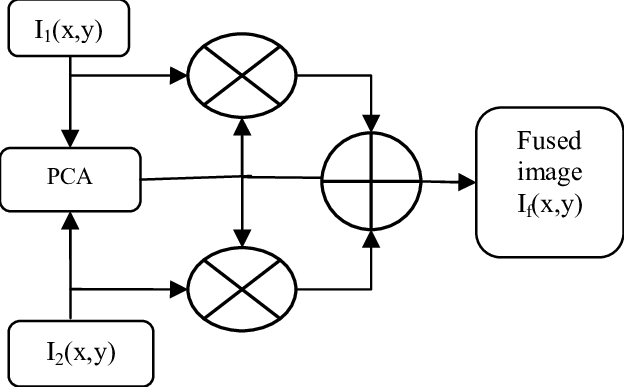

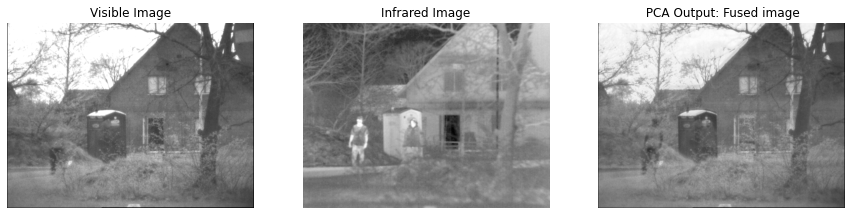

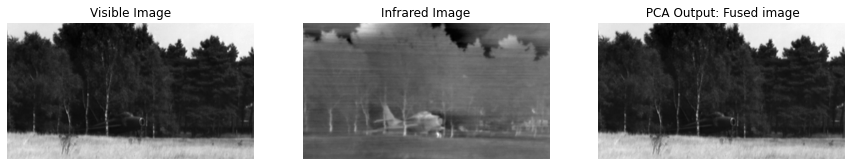

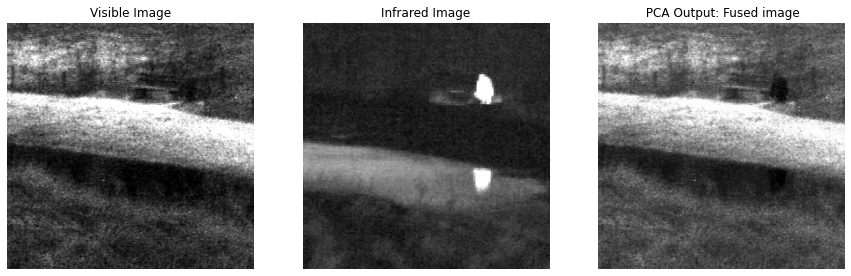

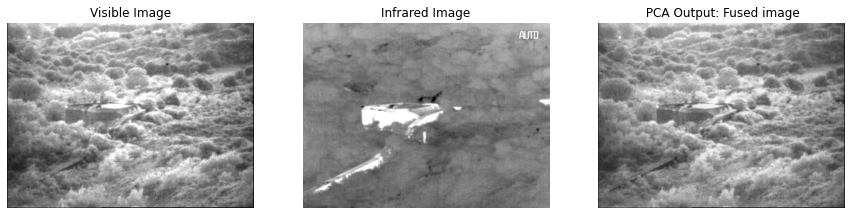

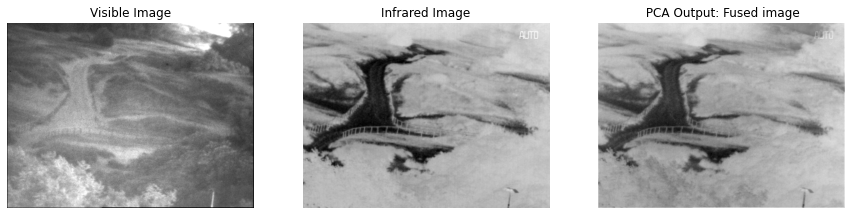

In [11]:
for id_x in range(6, 11, 1):

    gray_img = imread('IV_images/VIS%d.png' % id_x)
    ir_img = imread('IV_images/IR%d.png' % id_x)

    pic = Fusion_PCA(gray_img, ir_img)

    pict = pic * 255
    pict = pict.astype(np.uint8)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(gray_img, 'gray')
    plt.axis('off')
    plt.title('Visible Image')

    plt.subplot(1, 3, 2)
    plt.imshow(ir_img, 'gray')
    plt.axis('off')
    plt.title('Infrared Image')

    plt.subplot(1, 3, 3)
    plt.imshow(pic, 'gray')
    plt.axis('off')
    plt.title(' PCA Output: Fused image')
    plt.show()

### 3]Deep Learning Framework

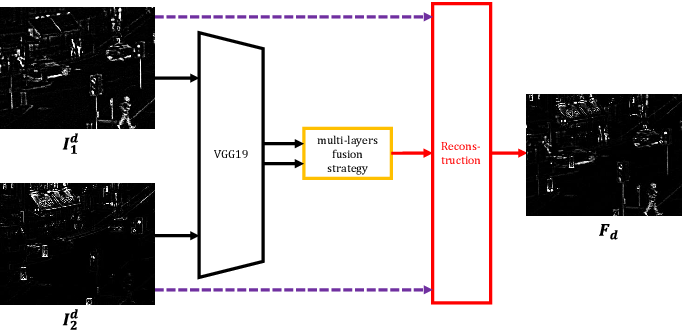

In [12]:
def fusion_strategy(feat_a, feat_b, source_a, source_b, img, unit):  # weighted-averaging method
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    weight_ave_temp3 = np.zeros((m1, n1))

    for i in range(1, m):
        for j in range(1, n):
            a1 = feat_a[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a2 = feat_b[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a3 = img[i - 1:i + 1, j - 1:j + 1].sum() / 9

            weight_ave_temp1[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a1 / (
                    a1 + a2 + a3)
            weight_ave_temp2[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a2 / (
                    a1 + a2 + a3)
            weight_ave_temp3[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a3 / (
                    a1 + a2 + a3)

    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    if img.ndim == 3:
        weight_ave_temp3 = weight_ave_temp3[:, :, None]
    source_img_fuse = img * weight_ave_temp3

    if source_a.ndim == 3 or source_b.ndim == 3 or img.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse) + np.atleast_3d(source_img_fuse)
    else:
        gen = source_a_fuse + source_b_fuse + source_img_fuse

    return gen


def fusion_strategy2(feat_a, feat_b, source_a, source_b, img1, img2, unit):
    m, n = feat_a.shape
    m1, n1 = source_a.shape[:2]
    weight_ave_temp1 = np.zeros((m1, n1))
    weight_ave_temp2 = np.zeros((m1, n1))
    weight_ave_temp3 = np.zeros((m1, n1))
    weight_ave_temp4 = np.zeros((m1, n1))

    for i in range(1, m):
        for j in range(1, n):
            a1 = feat_a[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a2 = feat_b[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a3 = img1[i - 1:i + 1, j - 1:j + 1].sum() / 9
            a4 = img2[i - 1:i + 1, j - 1:j + 1].sum() / 9

            weight_ave_temp1[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a1 / (
                    a1 + a2 + a3 + a4)
            weight_ave_temp2[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a2 / (
                    a1 + a2 + a3 + a4)
            weight_ave_temp3[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a3 / (
                    a1 + a2 + a3 + a4)
            weight_ave_temp4[(i - 2) * unit + 1:(i - 1) * unit + 1, (j - 2) * unit + 1:(j - 1) * unit + 1] = a4 / (
                    a1 + a2 + a3 + a4)

    if source_a.ndim == 3:
        weight_ave_temp1 = weight_ave_temp1[:, :, None]
    source_a_fuse = source_a * weight_ave_temp1
    if source_b.ndim == 3:
        weight_ave_temp2 = weight_ave_temp2[:, :, None]
    source_b_fuse = source_b * weight_ave_temp2
    if img1.ndim == 3:
        weight_ave_temp3 = weight_ave_temp3[:, :, None]
    source_img_fuse = img1 * weight_ave_temp3
    if img2.ndim == 3:
        weight_ave_temp4 = weight_ave_temp4[:, :, None]
    source_img2_fuse = img2 * weight_ave_temp4

    if source_a.ndim == 3 or source_b.ndim == 3 or img1.ndim == 3 or img2.ndim == 3:
        gen = np.atleast_3d(source_a_fuse) + np.atleast_3d(source_b_fuse) + np.atleast_3d(
            source_img_fuse) + np.atleast_3d(source_img2_fuse)
    else:
        gen = source_a_fuse + source_b_fuse + source_img_fuse + source_img2_fuse

    return gen


In [13]:
def fuse(vis, ir, model=None):
    npad = 16
    lda = 5
    vis_low, vis_high = lowpass(vis.astype(np.float32) / 255, lda, npad)
    ir_low, ir_high = lowpass(ir.astype(np.float32) / 255, lda, npad)

    img = Fusion_DWT_db2(vis.astype(np.float32) / 255, ir_high)
    img1 = Fusion_PCA(ir.astype(np.float32) / 255, ir_high)
    img2 = Fusion_PCA(vis_high, vis.astype(np.float32) / 255)
    snr = np.max(signaltonoise(img, axis=0, ddof=0))

    if model is None:
        model = vgg19(True)
    model.cuda().eval()
    relus = [2, 7, 12, 21]
    unit_relus = [1, 2, 4, 8]

    vis_in = torch.from_numpy(c3(vis_high)).cuda()
    ir_in = torch.from_numpy(c3(ir_high)).cuda()

    relus_vis = get_activation(model, relus, vis_in)
    relus_ir = get_activation(model, relus, ir_in)

    vis_feats = [l1_features(out) for out in relus_vis]
    ir_feats = [l1_features(out) for out in relus_ir]

    saliencies = []
    saliency_max = None

    if 10 < snr < 19:
        for idx in range(len(relus)):
            saliency_current = fusion_strategy(vis_feats[idx], ir_feats[idx],
                                               vis_high, ir_high, img, unit_relus[idx])
            saliencies.append(saliency_current)

            if saliency_max is None:
                saliency_max = saliency_current
            else:
                saliency_max = np.maximum(saliency_max, saliency_current)

    else:
        for idx in range(len(relus)):
            saliency_current = fusion_strategy2(vis_feats[idx], ir_feats[idx],
                                                vis_high, ir_high, img1, img2, unit_relus[idx])
            saliencies.append(saliency_current)

            if saliency_max is None:
                saliency_max = saliency_current
            else:
                saliency_max = np.maximum(saliency_max, saliency_current)

    if vis_low.ndim == 3 or ir_low.ndim == 3:
        low_fused = np.atleast_3d(vis_low) + np.atleast_3d(ir_low)
    else:
        low_fused = vis_low + ir_low
    low_fused = low_fused / 2
    high_fused = saliency_max

    return low_fused + high_fused


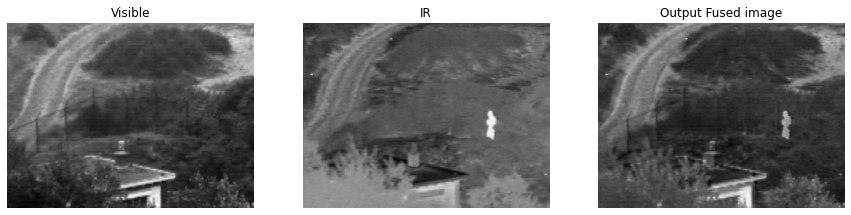

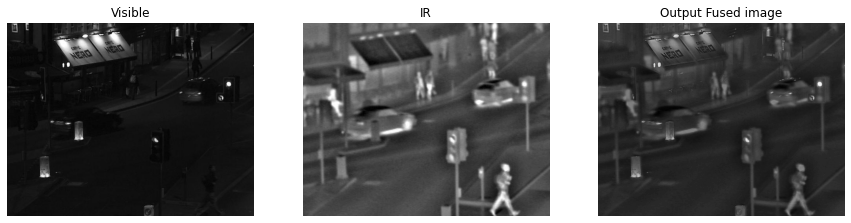

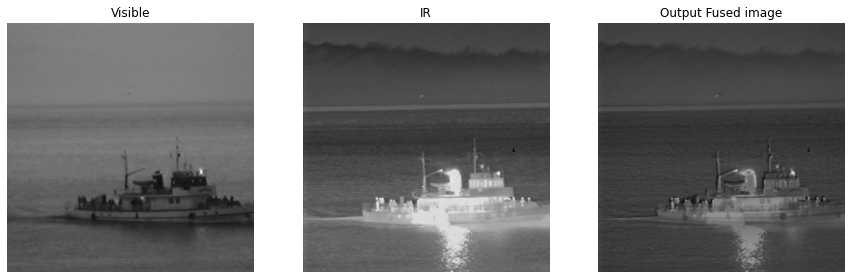

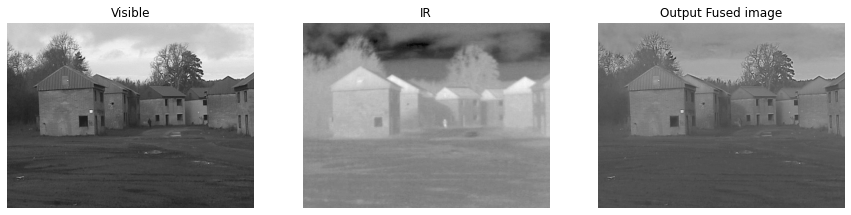

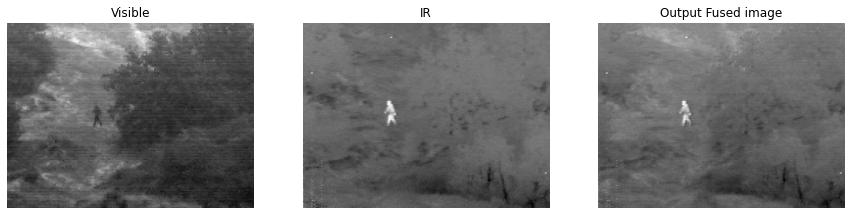

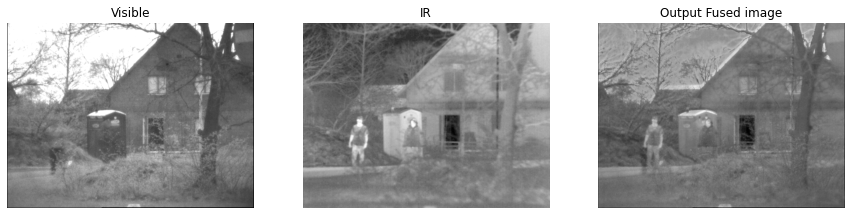

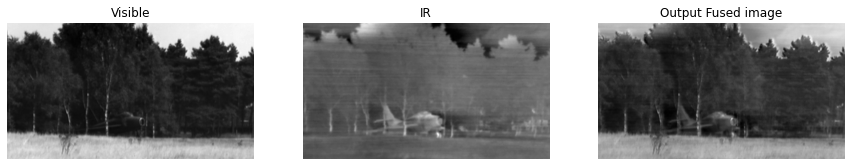

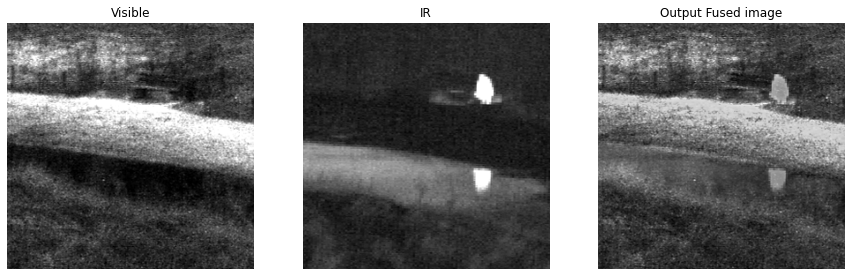

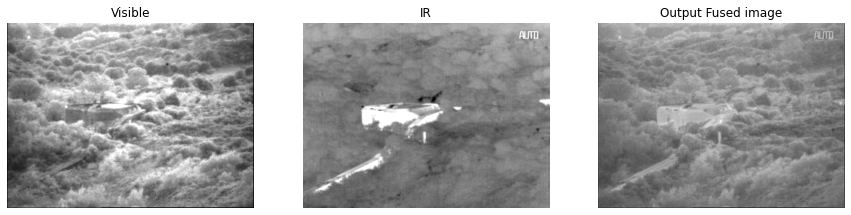

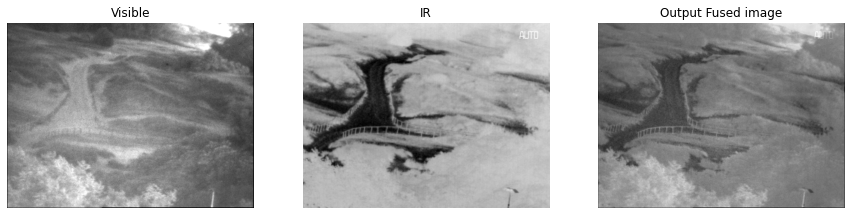

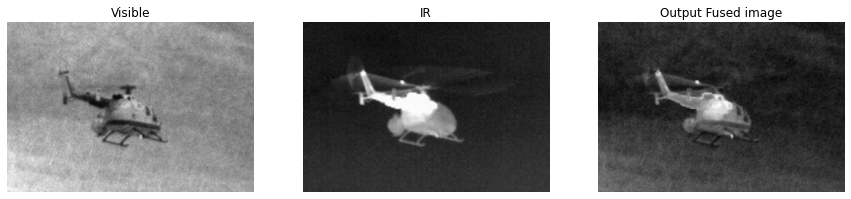

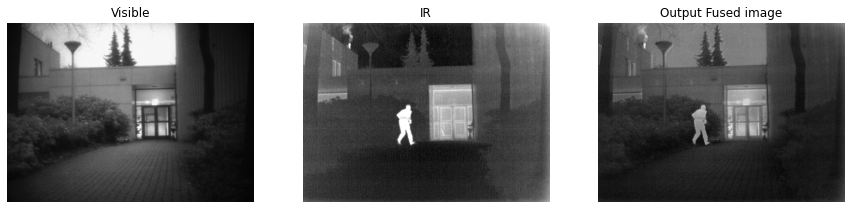

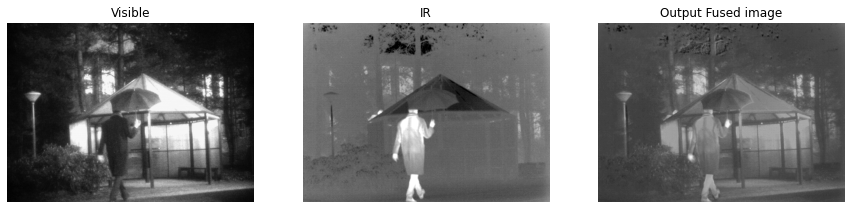

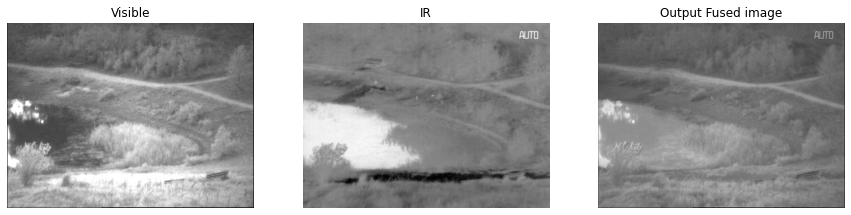

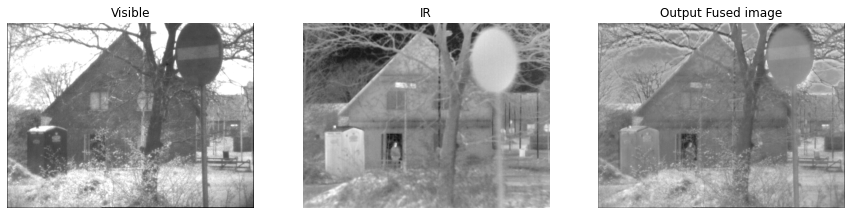

In [9]:
for id_x in range(1, 16, 1):

    gray_img = imread('IV_images/VIS%d.png' % id_x)
    ir_img = imread('IV_images/IR%d.png' % id_x)

    pic = fuse(gray_img, ir_img)

    #plt.imshow(pic, 'gray')
    #plt.axis('off')

    pict = pic * 255
    pict = pict.astype(np.uint8)
   # imsave("fused_image/fused%d.png" % id_x, pict)
    
    plt.figure(figsize=(15, 10))
    warnings.filterwarnings("ignore")
    #plt.subplot(2, 2, 1)
    plt.subplot(1, 3, 1)
    plt.imshow(gray_img, 'gray')
    plt.axis('off')
    plt.title('Visible Image')

    plt.subplot(1, 3, 2)
    plt.imshow(ir_img, 'gray')
    plt.axis('off')
    plt.title('Infrared Image')

    #plt.subplot(2, 2, 3)
    plt.subplot(1, 3, 3)
    plt.imshow(pic, 'gray')
    plt.axis('off')
    plt.title('Output Fused image')
    plt.show()

#### SNR values for each fused image:

In [16]:
from math import log10, sqrt
print("signal to noise ratio")
print("---------------------")
for idx in range(1, 16, 1):

    vis = imread('IV_images/VIS%d.png' % idx)
    ir = imread('IV_images/IR%d.png' % idx)

    npad = 16
    lda = 5
    vis_low, vis_high = lowpass(vis.astype(np.float32) / 255, lda, npad)
    ir_low, ir_high = lowpass(ir.astype(np.float32) / 255, lda, npad)

    img = fuse(vis.astype(np.float32) / 255, ir_high)
    snr=20*log10(np.max(signaltonoise(img, axis=0, ddof=0)))

    print("\n image_%2d: %5.2f" % (idx, snr))

signal to noise ratio
---------------------

 image_ 1: 12.85

 image_ 2: 12.90

 image_ 3: 19.98

 image_ 4:  8.24

 image_ 5: 25.11

 image_ 6: 15.26

 image_ 7:  7.87

 image_ 8:  4.72

 image_ 9: 14.63

 image_10: 14.91

 image_11: 29.10

 image_12: 18.79

 image_13: 17.29

 image_14: 13.62

 image_15: 16.63


### EVALUATION CRITERIA

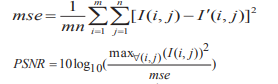

#### 1]Root Mean Square Error(RMSE)

In [19]:
def RMSE(original, fusedimage):
         mse = np.mean((original - fusedimage) ** 2)
         return np.sqrt(mse)
gray_img = imread('IV_images/VIS5.png' )
ir_img = imread('IV_images/IR5.png' )
original=(img1+img2)/2
fimg=Fusion_DWT_db2(img1,img2)
fimg2=Fusion_PCA(img1,img2) 
value1 = RMSE(original, fimg)
print(f"DWT: RMSE value is {value1} ")
value1 = RMSE(original, fimg2)
print(f"PCA: RMSE value is {value1} ")

DWT: RMSE value is 15.641052365124102 
PCA: RMSE value is 53.49376095832447 


#### 2] Peak Signal to Noise Ratio (PSNR)


In [20]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 10 * log10(max_pixel**2 / sqrt(mse))
    return psnr
from math import log10, sqrt
value1 = PSNR(original, fimg)
print(f"DWT: PSNR value is {value1} dB")
value1 = PSNR(original, fimg2)
print(f"PCA: PSNR value is {value1} dB")

DWT: PSNR value is 36.1881439085311 dB
PCA: PSNR value is 30.84777228180827 dB
